# Proyecto de Día 11 - Análisis Predictivo para una Tienda Minorista

### Objetivo
Tu tarea consiste en desarrollar un **modelo predictivo** para una **tienda minorista** que desea pronosticar las ventas basándose en diversas características. La tienda ha estado recopilando datos sobre las ventas diarias y quiere utilizar esta información para tomar decisiones informadas sobre la *gestión de inventario*, *promociones* y *programación de personal*.

Tu objetivo es construir un modelo que pueda **predecir el total de ventas para el próximo mes**, utilizando datos de los meses anteriores.

### Tarea
**1. Preparación de Datos**
- Carga el conjunto de datos y realiza cualquier preprocesamiento necesario, como manejar **valores faltantes**, selección de **variables dependientes e independientes**, y dividir los datos en **conjuntos de entrenamiento** y **prueba**.


**2. Análisis Exploratorio de Datos (EDA)**
- Realiza un EDA para entender la distribución de las ventas y la relación entre las ventas y otras características. Esto podría incluir trazar las ventas a lo largo del tiempo, analizar las ventas en *festivos* vs. *no festivos* y el impacto de las promociones.

**3. Selección de Modelo**
- Utiliza el conocimiento que has adquirido sobre diferentes algoritmos para elegir el modelo más adecuado para esta tarea. Considera la **Regresión Lineal**, los **Árboles de Decisión**, y los **Bosques Aleatorios**.

**4. Entrenamiento y Evaluación del Modelo**
- Entrena tu modelo seleccionado en el conjunto de entrenamiento y evalúa su rendimiento utilizando el conjunto de prueba. Utiliza gráficos para visualizar las *ventas reales* vs. *las predichas*.

**5. Conclusión**

- Basado en los resultados iniciales, resume tus hallazgos y realiza recomendaciones para la tienda minorista sobre cómo utilizar el análisis predictivo para una mejor toma de decisiones.


### Nota
* Enfócate en la claridad y simplicidad de tu código.

¡Mucha Suerte!

### 0. Cargar librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model as lm
import sklearn.tree as tr
import sklearn.model_selection as ms
import sklearn.preprocessing as sp
import sklearn.ensemble as se

### 1. Preparación de Datos

In [2]:
# Carga el conjunto de datos
df: pd.DataFrame = pd.read_csv('./data/Ventas.csv')
df

,Fecha,DíaDeLaSemana,Promociones,Festivo,Ventas
0,2022-01-01,6,0,0,4033
1,2022-01-02,7,0,1,4012
2,2022-01-03,1,0,0,1608
3,2022-01-04,2,1,0,2046
4,2022-01-05,3,0,0,2484
...,...,...,...,...,...
360,2022-12-27,2,1,0,2189
361,2022-12-28,3,0,0,2548
362,2022-12-29,4,0,0,3018
363,2022-12-30,5,0,0,3591


In [3]:
# Obtener información preliminar del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Fecha          365 non-null    object
 1   DíaDeLaSemana  365 non-null    int64 
 2   Promociones    365 non-null    int64 
 3   Festivo        365 non-null    int64 
 4   Ventas         365 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 14.4+ KB


In [4]:
# Obtener estadísticos generales del DataFrame
df.describe()

,DíaDeLaSemana,Promociones,Festivo,Ventas
count,365.000000,365.000000,365.000000,365.000000
mean,4.005479,0.200000,0.142466,2997.219178
std,2.002738,0.400549,0.350007,942.096284
min,1.000000,0.000000,0.000000,1305.000000
25%,2.000000,0.000000,0.000000,2195.000000
50%,4.000000,0.000000,0.000000,3074.000000
75%,6.000000,0.000000,0.000000,3979.000000
max,7.000000,1.000000,1.000000,4404.000000


El dataset entrega las ventas del negocio durante el año 2022. La columna `DíaDeLaSemana` indica el número del día de la semana en la que cae la fecha (`1` es lunes, `2` es martes, y así). Las columnas `Promociones` y `Festivo` parecen ser booleanos y simplemente indican si ese día hubo una promoción o fue un día festivo, respectivamente.

A primera vista, el dataset **no posee nulos**, por lo que se asume que todos los valores aquí proveídos son correctos (NOTA: Ok, el 1 de enero debería ser festivo y el 2 no, pero para efectos de este proyecto se puede dejar pasar, ya que no es el foco).

No obstante...

In [5]:
# Ver un elemento de la columna 'Fecha' y su tipo de dato
print(df['Fecha'][0])
print(type(df['Fecha'][0]))

2022-01-01
<class 'str'>


La columna `Fecha` es de tipo `str` (algo que siempre pasa al cargar el dataset desde CSV).

In [6]:
# Cambiar el tipo de dato de la columna 'Fecha' al tipo correcto
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m-%d', dayfirst=True)
print(df['Fecha'][0])
print(type(df['Fecha'][0]))

2022-01-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Ahora, es recomendable escalar los valores las columnas ajenas a `Fecha` y `Ventas`.

In [8]:
# Escalar las columnas, descartando 'Ventas' y 'Fecha'
scale: sp.MinMaxScaler = sp.MinMaxScaler(feature_range=(0, 1))
columns_to_scale: pd.Index = df.drop(['Ventas', 'Fecha'], axis=1).columns
scaled_columns: np.ndarray = scale.fit_transform(df[columns_to_scale])
scaled_columns

array([[0.83333333, 0.        , 0.        ],
       [1.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        ],
       ...,
       [0.5       , 0.        , 0.        ],
       [0.66666667, 0.        , 0.        ],
       [0.83333333, 1.        , 0.        ]])

In [9]:
# Crear un df con las columnas escaladas
df_scaled: pd.DataFrame = pd.DataFrame(
    scaled_columns, columns=columns_to_scale, index=df.index
)
df_scaled['Ventas'] = df['Ventas']
df_scaled['Fecha'] = df['Fecha']
df_scaled

,DíaDeLaSemana,Promociones,Festivo,Ventas,Fecha
0,0.833333,0.0,0.0,4033,2022-01-01
1,1.000000,0.0,1.0,4012,2022-01-02
2,0.000000,0.0,0.0,1608,2022-01-03
3,0.166667,1.0,0.0,2046,2022-01-04
4,0.333333,0.0,0.0,2484,2022-01-05
...,...,...,...,...,...
360,0.166667,1.0,0.0,2189,2022-12-27
361,0.333333,0.0,0.0,2548,2022-12-28
362,0.500000,0.0,0.0,3018,2022-12-29
363,0.666667,0.0,0.0,3591,2022-12-30


In [14]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DíaDeLaSemana  365 non-null    float64       
 1   Promociones    365 non-null    float64       
 2   Festivo        365 non-null    float64       
 3   Ventas         365 non-null    int64         
 4   Fecha          365 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 14.4 KB


Dado que el objetivo es **predecir el total de ventas para el próximo mes**, se deduce que la columna `Ventas` será la _variable dependiente_, mientras que las demás (salvo `Fecha`) cumplirán como _variables independientes_.

In [15]:
X: pd.DataFrame = df_scaled.drop(['Ventas', 'Fecha'], axis=1)
X.head()

,DíaDeLaSemana,Promociones,Festivo
0,0.833333,0.0,0.0
1,1.000000,0.0,1.0
2,0.000000,0.0,0.0
3,0.166667,1.0,0.0
4,0.333333,0.0,0.0


In [13]:
y: pd.Series = df['Ventas']
y.head()

0    4033
1    4012
2    1608
3    2046
4    2484
Name: Ventas, dtype: int64

In [16]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 2. Análisis Exploratorio de Datos (EDA)

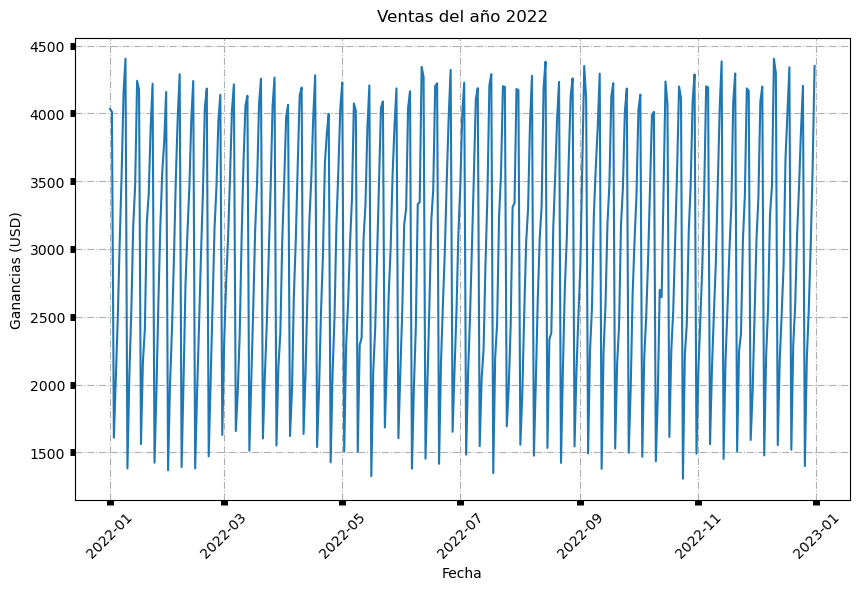

In [23]:
# Trazar las ventas a lo largo del tiempo
plt.figure(figsize=(10, 6))
plt.title('Ventas del año 2022', pad=12)
sns.lineplot(data=df, x='Fecha', y='Ventas')
plt.tick_params(width=5)
plt.xticks(rotation=45)
plt.grid(True, linestyle='-.')
plt.xlabel('Fecha')
plt.ylabel('Ganancias (USD)')
plt.show()

A primera vista, se observa una gran variabilidad en las ganancias de las ventas durante las semanas a través del año, lo que coincide con los datos estadísticos obtenidos preliminarmente. Sin embargo, esta gráfica de arriba puede verse demasiado "compacta" o "constreñida" para analizar detalles.

Veamos más claramente cómo se distribuyen las ventas por mes.

In [73]:
# Obtener el total de ventas por mes y guardarlo en un nuevo dataframe
df_ventas_mes: pd.DataFrame = pd.DataFrame(
    {'Mes': df['Fecha'].dt.month, 'Ventas': df['Ventas']}
).set_index('Mes').groupby('Mes').sum()
df_ventas_mes

,Ventas
Mes,
1,93268
2,82804
3,91872
4,91427
5,91056
6,89821
7,95539
8,90323
9,91079


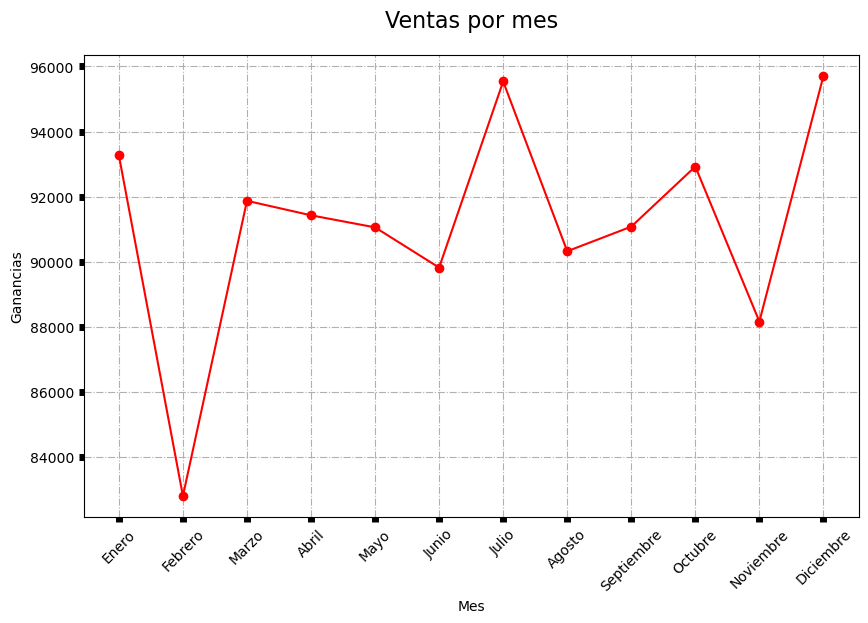

In [74]:
# Plotear el total de ventas por mes
meses: list[str] = [
    'Enero',
    'Febrero',
    'Marzo',
    'Abril',
    'Mayo',
    'Junio',
    'Julio',
    'Agosto',
    'Septiembre',
    'Octubre',
    'Noviembre',
    'Diciembre'
]

plt.figure(figsize=(10, 6))
plt.title('Ventas por mes', fontsize=16, pad=20)
plt.grid(True, linestyle='-.')
plt.plot(meses, df_ventas_mes['Ventas'], 'ro-')
plt.tick_params(width=5)
plt.xticks(rotation=45)
plt.xlabel('Mes')
plt.ylabel('Ganancias')
plt.show()

Los meses del 2022 con las **mayores ganancias** han sido **julio** y **diciembre**, mientras que las **menores ganancias** se obtuvieron en **febrero** y **noviembre**. Sin embargo, debido a que no hay información disponible de años previos, no se pueden extrapolar estas conclusiones de manera confiable.

Veamos ahora la distribución de las ventas por frecuencia.

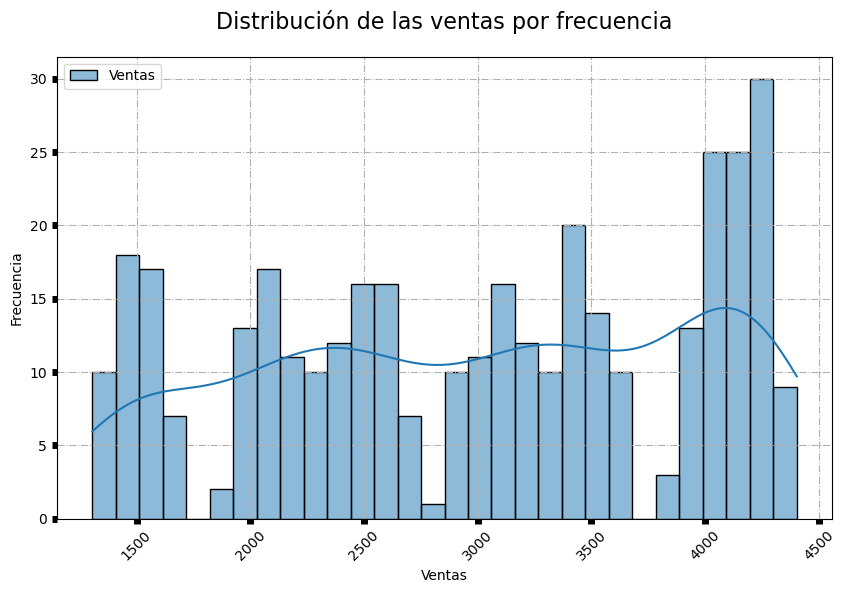

In [75]:
plt.figure(figsize=(10, 6))
plt.title('Distribución de las ventas por frecuencia', fontsize=16, pad=20)
plt.grid(True, linestyle='-.')
sns.histplot(df[['Ventas']], bins=30, kde=True)
plt.tick_params(width=5)
plt.xticks(rotation=45)
plt.xlabel('Ventas')
plt.ylabel('Frecuencia')
plt.show()

La distribución de las frecuencias con las que se repite una determinada cantidad de ventas diarias nos indica una gran variabilidad, consistente con la desviación estándar relativamente alta encontrada en los estadísticos descriptivos del dataset.

Veamos la relación entre las ganancias de las ventas y días de la semana.

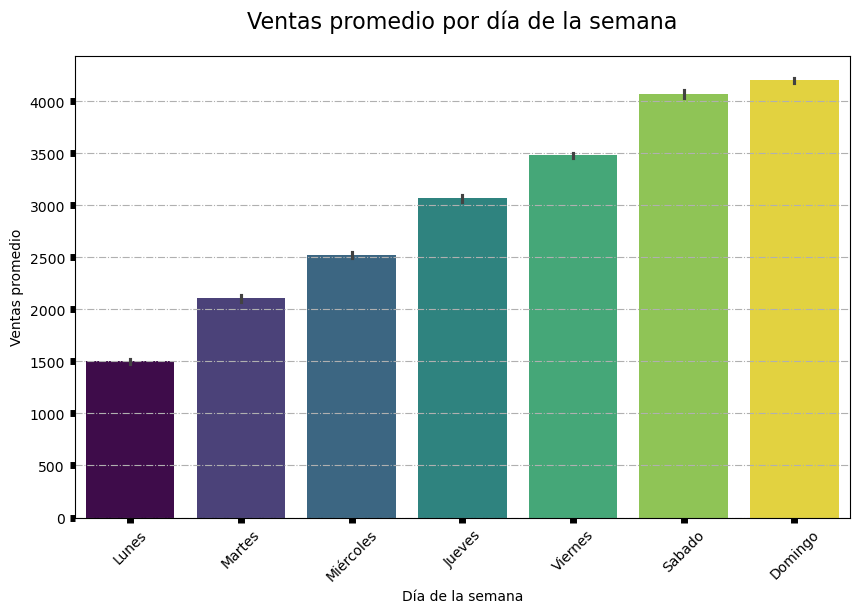

In [76]:
dias: list[str] = [
    'Lunes',
    'Martes',
    'Miércoles',
    'Jueves',
    'Viernes',
    'Sabado',
    'Domingo'
]
xticks: np.ndarray = df['DíaDeLaSemana'].unique() - 1  # índices
xticks.sort()

plt.figure(figsize=(10, 6))
plt.title('Ventas promedio por día de la semana', fontsize=16, pad=20)
plt.grid(True, linestyle='-.')
sns.barplot(
    df,
    x='DíaDeLaSemana',
    y='Ventas',
    hue='DíaDeLaSemana',
    palette='viridis',
    legend=False
)
plt.tick_params(width=5)
plt.xticks(ticks=xticks, labels=dias, rotation=45)
plt.xlabel('Día de la semana')
plt.ylabel('Ventas promedio')
plt.show()

Los clientes tienden a consumir más conforme se acerca el fin de semana, siendo los **lunes** los peores días, y los **domingos**, los mejores. Las líneas de error cortas nos indican una alta consistencia semana tras semana.

Observemos el efecto de las promociones en las ventas.

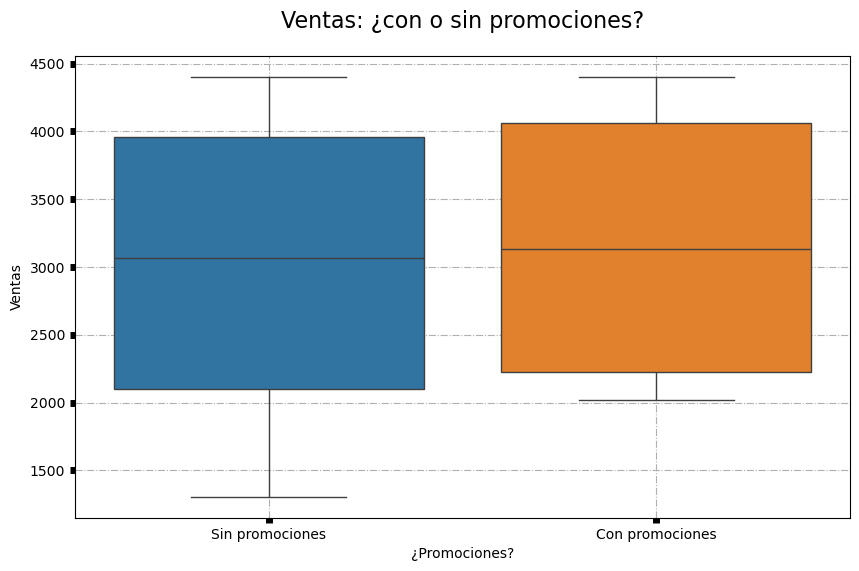

In [83]:
opciones: list[str] = ['Sin promociones', 'Con promociones']
xticks: np.ndarray = df['Promociones'].unique()  # índices
xticks.sort()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='Promociones',
    y='Ventas',
    hue='Promociones',
    legend=False
)
plt.tick_params(width=5)
plt.xticks(ticks=xticks, labels=opciones)
plt.title('Ventas: ¿con o sin promociones?', fontsize=16, pad=20)
plt.grid(True, linestyle='-.')
plt.xlabel('¿Promociones?')
plt.ylabel('Ventas')
plt.show()

La diferencia de las medianas y las cajas (entre los cuartiles 25 y 75) no parecen indicar una gran variabilidad en las ventas (solo un ligero desplazamiento de la caja hacia mayores ventas en los días con promociones). Tampoco se observa diferencias para el máximo de ventas entre ambos tipos de días. Sin embargo, los días con promociones sí manifiestan una variabilidad intercuartílica considerablemente menor que en los días sin promociones, donde los peores días de ventas con promociones hay al menos 2000 ventas diarias, mientras que pueden haber menos ventas (< 1500) en los días sin promociones.

Observemos el efecto de los días festivos en las ventas.

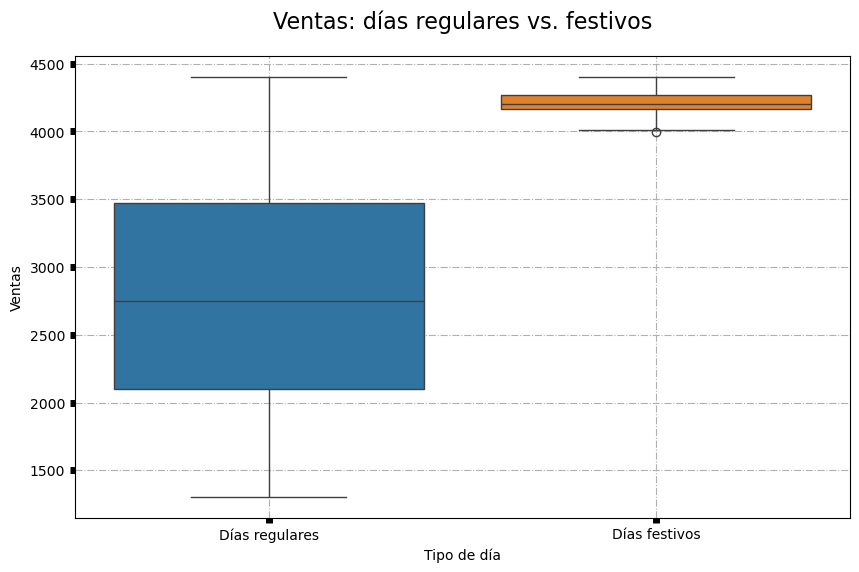

In [87]:
opciones: list[str] = ['Días regulares', 'Días festivos']
xticks: np.ndarray = df['Festivo'].unique()  # índices
xticks.sort()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='Festivo',
    y='Ventas',
    hue='Festivo',
    legend=False
)
plt.tick_params(width=5)
plt.xticks(ticks=xticks, labels=opciones)
plt.title('Ventas: días regulares vs. festivos', fontsize=16, pad=20)
plt.grid(True, linestyle='-.')
plt.xlabel('Tipo de día')
plt.ylabel('Ventas')
plt.show()

A diferencia de las promociones, aquí observamos una gran diferencia de las ventas entre días regulares y festivos, donde estos últimos tienen un impacto considerablemente más decisivo en las ventas, indicado por su rango intercuartíco mucho más compacto (comenzando desde las 4000 ventas) y su mediana más alta. Los días regulares poseen mayor variabilidad en las ventas diarias, similar a los días sin promociones vistos anteriormente.

Observemos la interacción entre promociones y días festivos en las ventas.

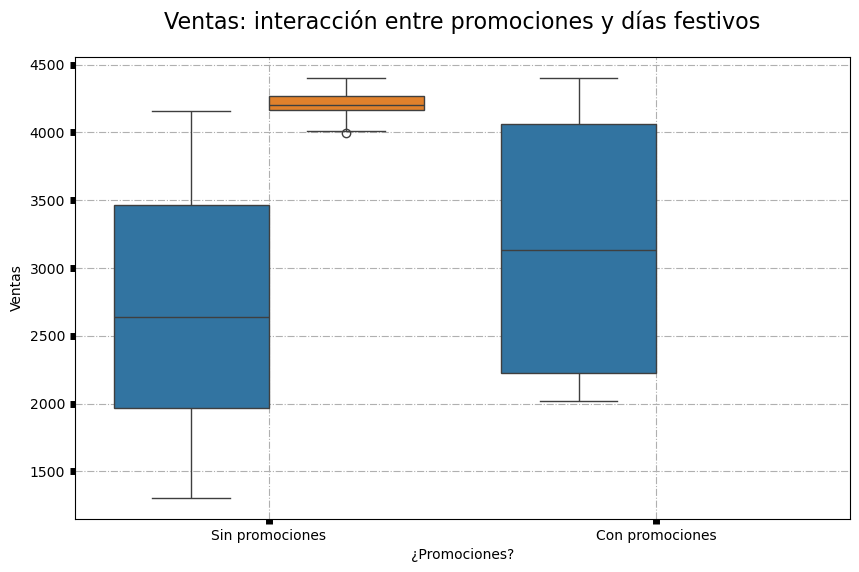

In [86]:
opciones: list[str] = ['Sin promociones', 'Con promociones']
xticks: np.ndarray = df['Promociones'].unique()  # índices
xticks.sort()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='Promociones',
    y='Ventas',
    hue='Festivo',
    legend=False
)
plt.tick_params(width=5)
plt.xticks(ticks=xticks, labels=opciones)
plt.title(
    'Ventas: interacción entre promociones y días festivos',
    fontsize=16,
    pad=20
)
plt.grid(True, linestyle='-.')
plt.xlabel('¿Promociones?')
plt.ylabel('Ventas')
plt.show()

Primero que todo, se observa que **no hay días festivos que incluyan promociones**. Por otro lado,el efecto de las promociones en las ventas es considerablemente menor al de los días festivos, siendo consistente con las observaciones en los dos gráficos anteriores y, por ende **las promociones no parecen ser tan buenos predictores de altas ventas** como sí los días festivos.